## Stable Diffusion on PVC with IPEX

This is a demo of [Stable Diffusion with the Hugging Face API](https://huggingface.co/stabilityai), and using the [Intel Extension for PyTorch](https://github.com/intel/intel-extension-for-pytorch) (IPEX) to optimize the model pipeline on Intel® Data Center GPU Max Series.

**Intro to Hardware: Intel® Data Center GPU Max Series**

- Up to 408MB of L2 Cache
- Built-in Ray Tracing Acceleration
- Intel® Xe Matrix Extensions (XMX)




In [1]:
! clinfo -l

Platform #0: Intel(R) OpenCL
 `-- Device #0: Intel(R) Xeon(R) Platinum 8480L
Platform #1: Intel(R) FPGA Emulation Platform for OpenCL(TM)
 `-- Device #0: Intel(R) FPGA Emulation Device
Platform #2: Intel(R) OpenCL Graphics
 +-- Device #0: Intel(R) Data Center GPU Max 1100
 +-- Device #1: Intel(R) Data Center GPU Max 1100
 +-- Device #2: Intel(R) Data Center GPU Max 1100
 `-- Device #3: Intel(R) Data Center GPU Max 1100
Platform #3: Intel(R) OpenCL
 `-- Device #0: Intel(R) Xeon(R) Platinum 8480L


**Intel Extension for PyTorch (IPEX-XPU)**
- Enable the pytorch workload on Intel GPUs
- Optimized kernels
- Operator Optimization and graph Optmization.


The demo consists of the following steps:

1. Load and define the core SD model components from HF.
2. Set up and run a standard SD pipeline with the HF API, i.e., generate a FP32 precision image on CPU.
3. Optimize SD with IPEX-XPU, run the SD on Intel® Data Center GPU Max 1100.
4. Compare the results wrt inference latency time.

#### Environment Setup  

Ensure ipex_xpu kernel is activated before running this demo.
If you can't find the ipex_xpu kernel, please go back to terminal and type ```source prepare_env.sh``` to prepare the environments for the workshop.


In [3]:
import torch

from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, DPMSolverMultistepScheduler, EulerDiscreteScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import matplotlib.pyplot as plt

import time

# Define model ID for SD version
model_id = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

**Single image inference**

The inference process can be different by changing the number of inference steps, we can govern the quality of the image, i.e., more steps equals better quality. Reduce the number of steps to receive results faster.

Please experiment with your own prompts!

  0%|          | 0/20 [00:00<?, ?it/s]

Generating one FP32 image took 49.43s


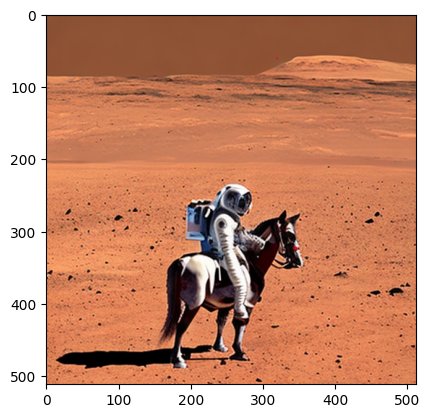

In [4]:
# Define the prompt for the image generation
prompt = "a photo of an astronaut riding a horse on mars"

# Set the number of iterations for the image generation
n_inf_steps = 20

# Simple timing of inference
start = time.time()
image = pipe(prompt, num_inference_steps=n_inf_steps).images[0]
end = time.time()
sd_cpu_t = end-start
print(f"Generating one FP32 image took {round(sd_cpu_t, 2)}s")

imgplot = plt.imshow(image)
plt.show()

**Optimization with IPEX**



/home/u137815/oneapi-devsummit-apj-2023/ipex_xpu/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/u137815/oneapi-devsummit-apj-2023/ipex_xpu/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:611: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/u137815/oneapi-devsummit-apj-2023/ipex_xpu/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

Generating one image on xpu took 9.23s


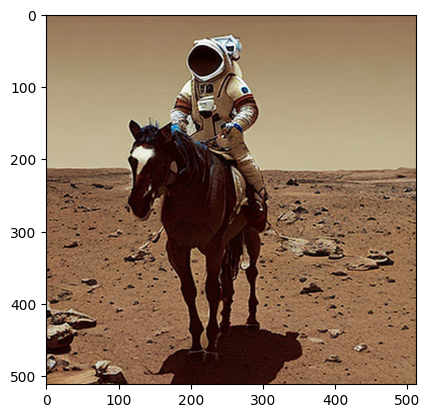

In [5]:
# Simple timing of inference on xpu

import intel_extension_for_pytorch as ipex


pipe = pipe.to('xpu')

# Put model in eval mode.
pipe.unet.eval()

# unet to device=xpu
pipe.unet = pipe.unet.to('xpu')

# Optimize the model w/ IPEX
pipe.unet = ipex.optimize(pipe.unet)

start = time.time()
image = pipe(prompt, num_inference_steps=n_inf_steps).images[0]
end = time.time()
sd_xpu_t = end-start
print(f"Generating one image on xpu took {round(sd_xpu_t, 2)}s")

imgplot = plt.imshow(image)
plt.show()

Inference with IPEX on XPU, was 10.35x faster.


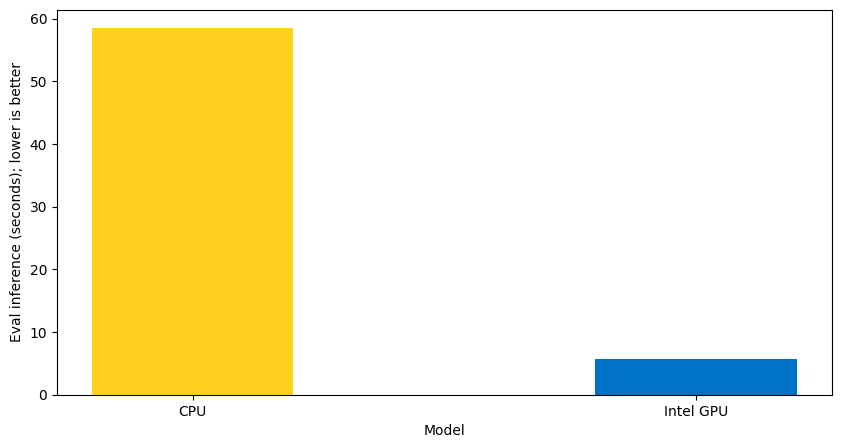

In [11]:
print(f"Inference with IPEX on XPU, was {round(sd_cpu_t/sd_xpu_t, 2)}x faster.")

def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color=['#ffd21e', '#0071c5'],width=0.4)
    plt.xlabel("Model")
    plt.ylabel("Eval inference (seconds); lower is better")
    plt.show()

outputDict={"CPU":sd_cpu_t,"Intel GPU":sd_xpu_t}
plotter(outputDict)